In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import re
from pathlib import Path

from src.mitigation import train_adult_income_logreg_fair_dp,train_german_credit_logreg_fair_dp
from src.data_loading import load_adult_income_dataset, load_german_credit_dataset
from src.fairness import metric_frame, fairness_summary_from_metric_frame

# Ensuring the output directory exists before writing any result tables or saving plots
# If results/ is missing, it will be created; if it already exists, nothing happens
RESULTS_DIR = Path("results")
PLOTS_DIR = RESULTS_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
def safe_filename(s: str) -> str:
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"[\s]+", "_", s)
    return s[:120]

def unique_path(base_path: Path) -> Path:
    # Avoiding overwriting: if file exists, add _2, _3, ...
    if not base_path.exists():
        return base_path
    stem = base_path.stem
    suffix = base_path.suffix
    i = 2
    while True:
        candidate = base_path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def save_plot(title: str, filename: str | None = None, dpi: int = 200):
    """
    Saving the current matplotlib figure to results/plots as PNG.
    """
    if filename is None:
        filename = safe_filename(title) or "plot"
        filename = filename + ".png"

    path = unique_path(PLOTS_DIR / filename)

    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    # marking current figure as already saved (prevents double-save if called twice)
    fig = plt.gcf()
    setattr(fig, "_autosave_done", True)

    print("Saved plot:", path.as_posix())


# auto save feature when plt.show() is called
_ORIGINAL_SHOW = plt.show  # keeping reference so it can be restored if needed
_PLOT_COUNTER = 0

def get_current_plot_title() -> str:
    fig = plt.gcf()

    # Trying suptitle first
    st = getattr(fig, "_suptitle", None)
    if st is not None and st.get_text().strip():
        return st.get_text().strip()

    # Fallback to first axes title
    axes = fig.get_axes()
    if axes and axes[0].get_title().strip():
        return axes[0].get_title().strip()

    return ""

def autosave_current_figure_if_needed():
    global _PLOT_COUNTER
    fig = plt.gcf()

    # If this figure was already saved, skip (prevents duplicates)
    if getattr(fig, "_autosave_done", False):
        return

    title = get_current_plot_title()
    if not title:
        _PLOT_COUNTER += 1
        title = f"plot_{_PLOT_COUNTER:03d}"

    save_plot(title)

def show(*args, **kwargs):
    # Saving before showing
    try:
        autosave_current_figure_if_needed()
    except Exception as e:
        print("WARNING: autosave failed:", e)

    return _ORIGINAL_SHOW(*args, **kwargs)

# Monkey-patch matplotlib show
plt.show = show
print("Autosave enabled: every plt.show() will also save a PNG to results/plots/")

Autosave enabled: every plt.show() will also save a PNG to results/plots/


In [3]:
# Loading the TEST splits for both datasets (these will be used only for evaluation of the mitigated models)
X_test_a, y_test_a, A_test_a, df_test_a = load_adult_income_dataset("test")
X_test_g, y_test_g, A_test_g, df_test_g = load_german_credit_dataset("test")

# Extracting the protected attributes from the test DataFrames explicitly
# Even though X is "unaware", A is used for fairness evaluation
A_sex = df_test_a["sex"]
A_pss = df_test_g["personal_status_sex"]


In [4]:
# Sweeping over multiple eps values for ExponentiatedGradient(DemographicParity) to study the
# fairness–accuracy trade-off, Smaller eps enforces the fairness constraint more strictly,
# which often improves fairness metrics but can reduce accuracy
eps_values = [0.005, 0.01, 0.02, 0.05]

# Collecting summary rows for each eps setting (one row per eps) for both datasets.
rows_adult = []
rows_german = []

for eps in eps_values:
    # Adult Income: training mitigated model (Demographic Parity) 
    adult_mit = train_adult_income_logreg_fair_dp(eps=eps)
    # Predicting on the test split and compute group-aware metrics using A_sex
    y_pred_a = adult_mit.predict(X_test_a)
    mf_a = metric_frame(y_test_a, y_pred_a, A_sex)
    # Converting the MetricFrame into a single summary row
    rows_adult.append(fairness_summary_from_metric_frame(mf_a, model_name=f"logreg_fair_dp_eps{eps}", dataset_name="adult_income"))

    # German Credit: training mitigated model (Demographic Parity)
    german_mit = train_german_credit_logreg_fair_dp(eps=eps)
    # Predicting on the test split and compute group-aware metrics using A_pss
    y_pred_g = german_mit.predict(X_test_g)
    mf_g = metric_frame(y_test_g, y_pred_g, A_pss)
    rows_german.append(fairness_summary_from_metric_frame(mf_g, model_name=f"logreg_fair_dp_eps{eps}", dataset_name="german_credit"))

# Building result tables (one row per eps value) for easy comparison and plotting
adult_dp_sweep = pd.DataFrame(rows_adult)
german_dp_sweep = pd.DataFrame(rows_german)

display(adult_dp_sweep)
display(german_dp_sweep)

# Saving sweep tables for reproducibility 
adult_dp_sweep.to_csv("results/adult_logreg_dp_sweep.csv", index=False)
german_dp_sweep.to_csv("results/german_logreg_dp_sweep.csv", index=False)

print("Saved: results/adult_logreg_dp_sweep.csv")
print("Saved: results/german_logreg_dp_sweep.csv")


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,predictive_parity_diff
0,adult_income,logreg_fair_dp_eps0.005,0.827756,0.723887,0.483243,0.579579,0.013529,0.919673,0.261722,0.299841
1,adult_income,logreg_fair_dp_eps0.01,0.828353,0.726718,0.482973,0.580289,0.014560,0.913351,0.262040,0.296375
2,adult_income,logreg_fair_dp_eps0.02,0.828088,0.726089,0.482162,0.579503,0.014362,0.914424,0.262995,0.295574
3,adult_income,logreg_fair_dp_eps0.05,0.828685,0.726354,0.485676,0.582119,0.016340,0.903660,0.260972,0.291983


,dataset,model,accuracy,precision,recall,f1,statistical_parity_diff,disparate_impact_ratio,equal_opportunity_diff,predictive_parity_diff
0,german_credit,logreg_fair_dp_eps0.005,0.695,0.780142,0.785714,0.782918,0.525,0.416667,0.25641,0.177489
1,german_credit,logreg_fair_dp_eps0.01,0.705,0.783217,0.800000,0.791519,0.525,0.416667,0.25641,0.170833
2,german_credit,logreg_fair_dp_eps0.02,0.710,0.792857,0.792857,0.792857,0.475,0.441176,0.25641,0.190476
3,german_credit,logreg_fair_dp_eps0.05,0.715,0.790210,0.807143,0.798587,0.475,0.441176,0.25641,0.194093


Saved: results/adult_logreg_dp_sweep.csv
Saved: results/german_logreg_dp_sweep.csv


Saved plot: results/plots/adult_income_dp_mitigation_eps_sweep_accuracy_vs_spd.png


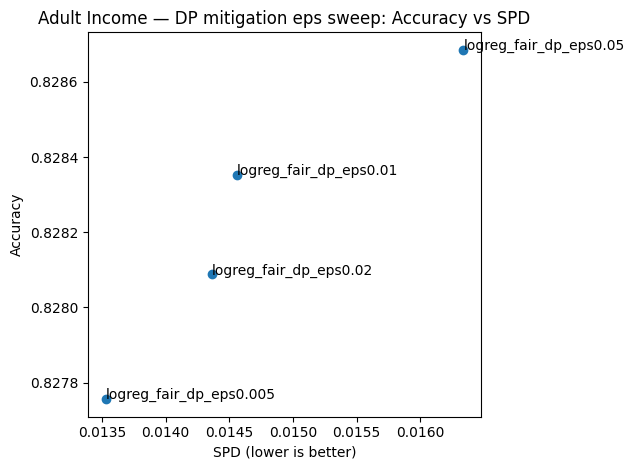

In [5]:
# Plotting the fairness–performance trade-off for the Demographic Parity (DP) mitigation sweep on Adult Income
# Each point corresponds to one eps value of ExponentiatedGradient
# x-axis = Statistical Parity Difference (SPD): lower is typically "fairer"
# y-axis = Accuracy: higher is better predictive performance

df = adult_dp_sweep.copy()

plt.figure()
plt.scatter(df["statistical_parity_diff"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["statistical_parity_diff"], r["accuracy"], r["model"])
plt.title("Adult Income — DP mitigation eps sweep: Accuracy vs SPD")
plt.xlabel("SPD (lower is better)")
plt.ylabel("Accuracy")
plt.show()


Saved plot: results/plots/german_credit_dp_mitigation_eps_sweep_accuracy_vs_spd.png


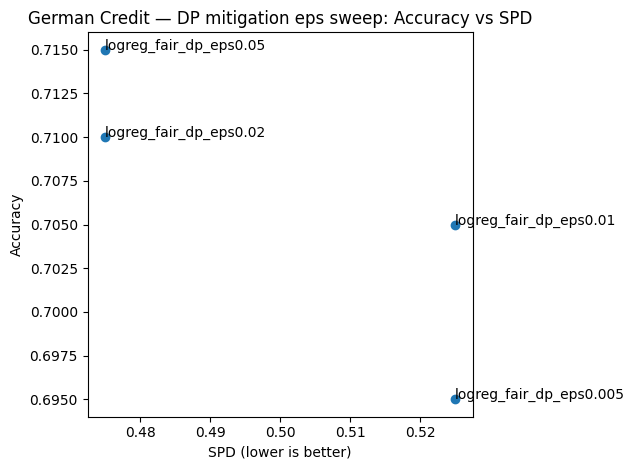

In [6]:
# Plotting the fairness–performance trade-off for the Demographic Parity (DP) mitigation sweep on German Credit
# Each point corresponds to one eps value (constraint strength) of ExponentiatedGradient
# x-axis = Statistical Parity Difference (SPD): lower is typically "fairer"
# y-axis = Accuracy: higher is better predictive performance
df = german_dp_sweep.copy()

plt.figure()
plt.scatter(df["statistical_parity_diff"], df["accuracy"])
for _, r in df.iterrows():
    plt.text(r["statistical_parity_diff"], r["accuracy"], r["model"])
plt.title("German Credit — DP mitigation eps sweep: Accuracy vs SPD")
plt.xlabel("SPD (lower is better)")
plt.ylabel("Accuracy")
plt.show()
